This script performs GSEA analysis based on the gene ranking results in the previous steps

In [10]:
import pickle
import os

with open('results/gene_selection_ranking/all_selected_ranked_hlca_nonsmoker.pickle', 'rb') as handle:
    res1 = pickle.load(handle)
with open('results/gene_selection_ranking/all_selected_ranked_hlca_smoker.pickle', 'rb') as handle:
    res2 = pickle.load(handle)

for i in range(len(res1)):
    res1[i] = list(res1[i])
    res1[i].append("HLCA")

for i in range(len(res2)):
    res2[i] = list(res2[i])
    res2[i].append("HLCA")

In [2]:
res = res1 + res2

In [3]:
all_genes = {"HLCA":dict(),"nuc-seq":dict()}
for ct_column,group,ct,gene_type,use_pca,nz_idx,gene_names,feature_names,pca_model,donor_num,scores,pvals,dataset in res:
    
    if gene_type == "all_nonsmoker" or gene_type == "all_smoker":
        all_genes[dataset][group] = gene_names

**Load senescence markers**

In [4]:
from functools import reduce
import pandas as pd
import numpy as np

test_genes = {"fridman":["ALDH1A3", "AOPEP", "CCND1", "CD44", "CDKN1A", "CDKN1C", "CDKN2A", "CDKN2B", "CDKN2D", "CITED2",
                                "CLTB", "COL1A2","CREG1","CRYAB","CCN2","CXCL14","CYP1B1","EIF2S2","ESM1","F3","FILIP1L","FN1","GSN","GUK1","HBS1L",
                                "HPS5","HSPA2","HTATIP2","IFI16","IFNG","IGFBP1","IGFBP2","IGFBP3","IGFBP4","IGFBP5","IGFBP6","IGFBP7","IGSF3",
                                "ING1","IRF5","IRF7","ISG15","MAP1LC3B","MAP2K3","MDM2","MMP1","NDN","NME2","NRG1","OPTN","PEA15","RAB13","RAB31",
                                "RAB5B","RABGGTA","RAC1","RBL2","RGL2","RHOB","RRAS","S100A11","SERPINB2","SERPINE1","SMPD1","SMURF2","SOD1","SPARC",
                                "STAT1","TES","TFAP2A","TGFB1I1","THBS1","TNFAIP2","TNFAIP3","TP53","TSPYL5","VIM","ALDH1A1","BMI1","CCNB1","CDC25B",
                                "CKS1BP7","COL3A1","E2F4","EGR1","ID1","LAMA1","LDB2","MARCKS","CCN4"],
              "sasp2":["VEGFA", "TNFRSF12A", "TNFRSF10C", "TNFRSF10B", "TIMP2", "TIMP1", "TGFB1", "SERPINE1", "TNFRSF1A",
                                    "PLAUR", "PLAU", "MMP14", "MMP13", "MMP7", "MMP3", "MIF", "LMNA", "KITLG", "IL32", "IGFBP7", "IGFBP2",
                                     "ICAM1", "FAS", "EREG", "CXCL17", "CXCL16", "CXCL8", "CXCL1", "CTSB", "CLU", "CCL20", "CCL2", "BTC",
                                     "AREG"
                                  ],
              "senmayo":pd.read_excel("data/senescence_list.xlsx",sheet_name="SenMayo")["symbol"].tolist(),
              "cellage":pd.read_excel("data/senescence_list.xlsx",sheet_name="CellAge Senescence Genes")["Symbol"].tolist()
                }

test_genes["union"] = reduce(np.union1d, [test_genes["fridman"],
                    test_genes["sasp2"],
                    test_genes["senmayo"],
                    test_genes["cellage"]]
      )

Perform GSEA analysis for selected cell types

In [ ]:
recs = {"HLCA":{"smoker":dict(),"nonsmoker":dict()},"nuc-seq":{"smoker":dict(),"nonsmoker":dict()}}
import re
from gseapy import prerank,enrichr
from textwrap import wrap
import numpy as np
import pandas as pd
from tqdm import tqdm

for ct_column,group,ct,gene_type,use_pca,nz_idx,gene_names,feature_names,pca_model,donor_num,scores,pvals,dataset in tqdm(res):
    select = (ct == "Basal" or ct == "Basal resting" or ct == "Suprabasal" and group == "nonsmoker" and dataset == "HLCA") or \
    (ct == "Smooth muscle" or ct == "EC venous systemic" and group == "smoker" and dataset == "HLCA") or \
    (ct == "Macrophage.type2" and group == "nonsmoker" and dataset == "nuc-seq")
    
    gene_set_files = [
        "data/KEGG_2021_Human.gmt",
        "data/Elsevier_Pathway_Collection.gmt",
        "data/GO_Biological_Process_2021.gmt"
    ]
    if select:
        gsea = prerank(rnk = scores,
                     gene_sets = gene_set_files,
                     processes = 4,
                     permutation_num = 100,
                     min_size = 5,
                     max_size = 1000,
                     outdir = None,
                     seed = 1000)
        
        overrep = enr = enrichr(
                     gene_list = pvals[pvals <= 0.05].index.tolist(),
                     gene_sets = gene_set_files,
                     organism = "human",
                     background = scores.index.tolist(),
                     outdir = None
                    )
        
        gsea.res2d["Gene_set"] = "GO_Biological_Process_2021.gmt"
        gsea.res2d.loc[gsea.res2d["Term"].str.match("Elsevier_Pathway_Collection.gmt__"),"Gene_set"] = "Elsevier_Pathway_Collection.gmt"
        gsea.res2d.loc[gsea.res2d["Term"].str.match("KEGG_2021_Human.gmt__"),"Gene_set"] = "KEGG_2021_Human.gmt"
                                                               
        gsea.res2d.replace(to_replace = "GO_Biological_Process_2021.gmt__",value = "",regex = True,inplace = True)
        gsea.res2d.replace(to_replace = "Elsevier_Pathway_Collection.gmt__",value = "",regex = True,inplace = True)
        gsea.res2d.replace(to_replace = "KEGG_2021_Human.gmt__",value = "",regex = True,inplace = True)
        
        overrep.results.replace(to_replace = "GO_Biological_Process_2021.gmt__",value = "",regex = True,inplace = True)
        overrep.results.replace(to_replace = "Elsevier_Pathway_Collection.gmt__",value = "",regex = True,inplace = True)
        overrep.results.replace(to_replace = "KEGG_2021_Human.gmt__",value = "",regex = True,inplace = True)
        
        sig_gsea = gsea.res2d.loc[gsea.res2d["FDR q-val"] <= 0.05,]
        sig_overrep = overrep.results.loc[overrep.results["Adjusted P-value"] <= 0.05,]
        
        if sig_gsea.shape[0] > 0:
            for idx,row in sig_gsea.iterrows():
                sig_gsea.loc[idx,"Term"] = "\n".join(wrap(row["Term"], 40))
                sig_gsea.loc[idx,"NES"] = np.round(row["NES"],4)
        
        if sig_overrep.shape[0] > 0:
            for idx,row in sig_overrep.iterrows():
                sig_overrep.loc[idx,"Term"] = "\n".join(wrap(row["Term"], 40))
        
        recs[dataset][group][ct]=[sig_gsea,sig_overrep]

**Plot fig 5B**

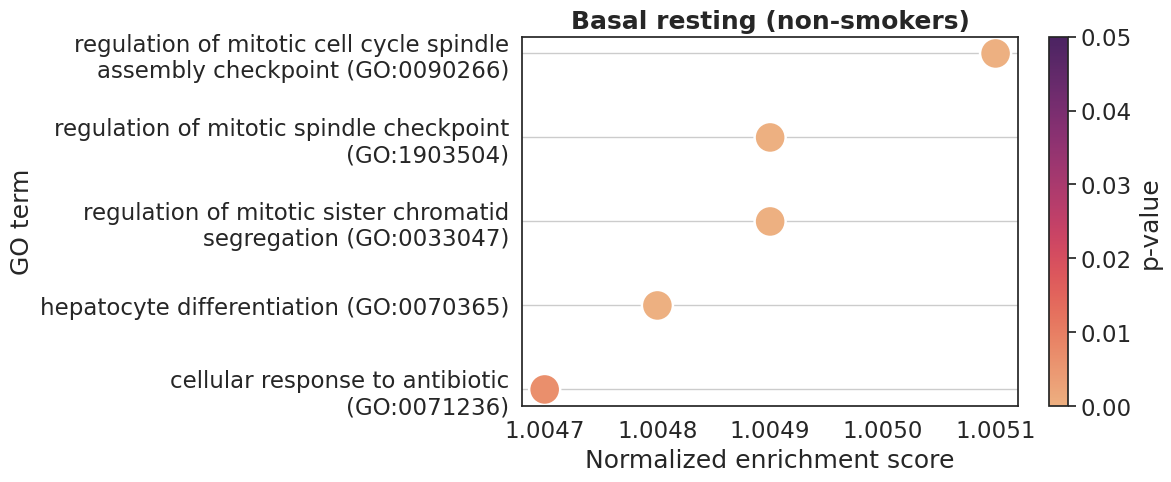

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

n_top = 5
plt_data = recs["HLCA"]["nonsmoker"]["Basal resting"][0]
plt_data = plt_data.loc[plt_data["Gene_set"] == "GO_Biological_Process_2021.gmt"].iloc[:n_top,]

plt_data["FDR q-val"] = plt_data["FDR q-val"].astype(float)
plt_data["FDR q-val"] = plt_data["FDR q-val"]

norm = plt.Normalize(0,0.05)
sm = plt.cm.ScalarMappable(cmap = "flare", norm = norm)
sm.set_array([])

sns.set(font_scale = 1.5, style="white")
fig, ax = plt.subplots(figsize = (8,4.8))
ax = sns.scatterplot(data = plt_data,
              x = "NES",
              y = "Term",
              hue = "FDR q-val",
              hue_norm = (0,0.05),
              s = 500,
              palette="flare",
              ax = ax
             )
ax.get_legend().remove()
ax.grid(axis = 'y')
ax.locator_params(axis = "x", nbins = 5)

plt.colorbar(sm, ax=ax, label = "p-value")
ax.set_xlabel("Normalized enrichment score")
ax.set_ylabel("GO term")
ax.set_title("Basal resting (non-smokers)", fontdict={"weight":"bold"})

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/GSEA_fig5b1.svg")

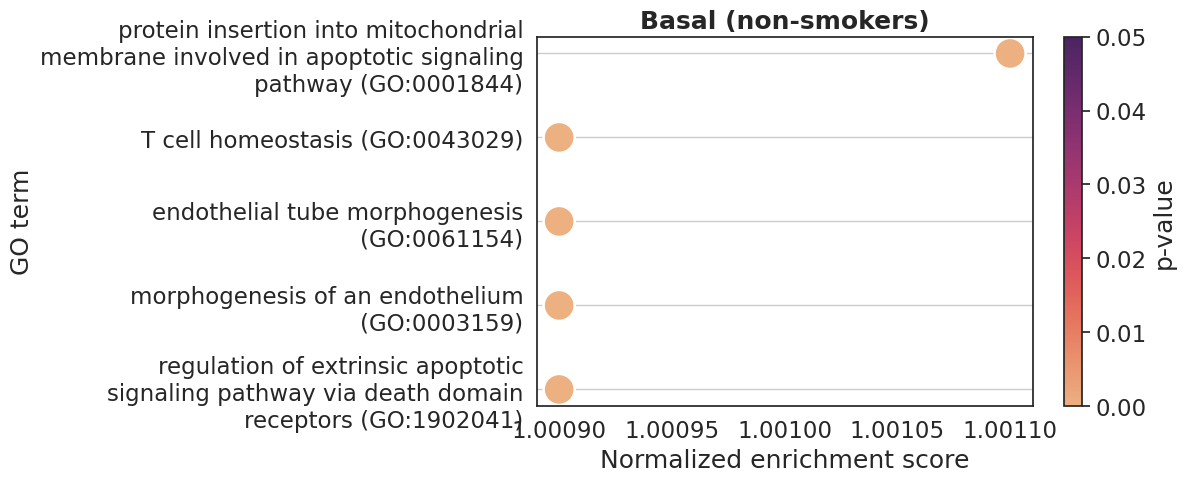

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

n_top = 5

plt_data = recs["HLCA"]["nonsmoker"]["Basal"][0]
plt_data = plt_data.loc[plt_data["Gene_set"] == "GO_Biological_Process_2021.gmt"].iloc[:n_top,]

plt_data["FDR q-val"] = plt_data["FDR q-val"].astype(float)
plt_data["FDR q-val"] = plt_data["FDR q-val"]

norm = plt.Normalize(0,0.05)
sm = plt.cm.ScalarMappable(cmap = "flare", norm = norm)
sm.set_array([])

sns.set(font_scale = 1.5, style="white")
fig, ax = plt.subplots(figsize = (8,4.8))
ax = sns.scatterplot(data = plt_data,
              x = "NES",
              y = "Term",
              hue = "FDR q-val",
              hue_norm = (0,0.05),
              s = 500,
              palette="flare",
              ax = ax
             )
ax.get_legend().remove()
ax.grid(axis = 'y')
ax.locator_params(axis = "x", nbins = 5)

plt.colorbar(sm, ax=ax, label = "p-value")
ax.set_xlabel("Normalized enrichment score")
ax.set_ylabel("GO term")
ax.set_title("Basal (non-smokers)", fontdict={"weight":"bold"})

if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/GSEA_fig5b2.svg")

**Save GSEA results for basal-related cells**

In [14]:
with pd.ExcelWriter("results/gsea_nonsmoker_hlca.xlsx") as writer: 
    recs["HLCA"]["nonsmoker"]["Basal"][1].to_excel(writer, sheet_name = "Basal")
    recs["HLCA"]["nonsmoker"]["Basal resting"][1].to_excel(writer, sheet_name = "Basal resting")
    recs["HLCA"]["nonsmoker"]["Suprabasal"][1].to_excel(writer, sheet_name = "Suprabasal")

**Whether these genes are in senescence markers?**

In [15]:
genes = np.array(["PMAIP1","NOXA","APR","DUSP1","CD74","DNAJB1","ANXA1","CRIP1","KDF1","RHOB"])

In [16]:
np.intersect1d(genes,test_genes["union"])

array(['RHOB'], dtype='<U9')